In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
import statsmodels.formula.api as smf
import pickle

from src.data.some_dataloader import RedditDataset

In [16]:
dataset = RedditDataset()
data = dataset.data
body = dataset.data_body

In [ ]:
from datetime import datetime

def train_logit_link_sentiment(df, properties, save_path):
    """ Plots a bar plot of the mean sentiment link per month

    Args:
        df (df): dataframe containing 'LINK_SENTIMENT' and 'PROPERTIES'
        properties (int[]): list of the properties to use for logit, the number refers to 
            the place of the property in the vector 'PROPERTIES' as given in the paper
        save_path (str): save model in this file
    """

    # check properties are in the reddit dataset
    for p in properties:
        if p < 1 or p > 86:
            raise ValueError('Prperties must be between 1 and 86.')
    
    # check dataframe has LINK_SENTIMENT 
    if 'LINK_SENTIMENT' not in df.columns:
        raise ValueError("LINK_SENTIMENT column is missing")

    # Expand property vectors into individual columns
    prop_df = pd.DataFrame(df['PROPERTIES'].tolist())
    prop_df.columns = [f"prop_{i+1}" for i in range(prop_df.shape[1])]
    selected_cols = [prop_df.columns[i-1] for i in properties]
    df = pd.concat([df, prop_df[selected_cols]], axis=1)

    # logistic regression demands value 0 or 1 (-1.0 => 0.0)
    df['LINK_SENTIMENT'] = df['LINK_SENTIMENT'].astype(float)
    df["LINK_SENTIMENT"] = df["LINK_SENTIMENT"].replace(-1.0, 0.0)

    # Fit model
    formula = "LINK_SENTIMENT ~ " + " + ".join(selected_cols)
    model = smf.logit(formula=formula, data=df).fit(disp=False)

    # Save model to path
    with open(save_path, "wb") as f:
        pickle.dump(model, f)

    print(f"Model saved to {save_path}")
    print(model.summary())


def train_logit_link_sentiment_timewindow(df, properties, save_path, from_date, to_date):
    """ Train 
    
    Args:
        data (df): dataframe containing 'LINK_SENTIMENT', 'TIMESTAMP' and 'PROPERTIES'
        properties (int[]): list of the properties to use for logit, the number refers to 
            the place of the property in the vector 'PROPERIES' as given in the paper
        save_path (str): file path to save the model 
        from_date (str): 'YYYY-MM-DD' Start date included
        to_date (str): 'YYYY-MM-DD' End date excluded
    """

    window_df = get_df_time_window(df, from_date, to_date)
    train_logit_link_sentiment(window_df, properties, save_path)


def get_df_time_window(df, from_date, to_date):
    """ Get dataframe of rows for which TIMESTAMP is in time window [from_date, to_date)

    Args:
        df (df): dataframe containing 'TIMESTAMP'
        from_date (str): 'YYYY-MM-DD' Start date included
        to_date (str): 'YYYY-MM-DD' End date excluded

    Returns:
        window_df (df): dataframe with only the rows over time window given
    """

    for date in (from_date, to_date):
        try:
            datetime.strptime(date, "%Y-%m-%d")
        except ValueError:
            raise ValueError(f"Invalid date format: '{date}'. Expected 'YYYY-MM-DD'.")

    window_df = df[(df['TIMESTAMP'] >= from_date) & (df['TIMESTAMP'] < to_date)]
    return window_df
    


In [13]:
properties_test = [5, 10, 15, 20]
path_test = 'src/models/properties_logitreg_test.pkl'
train_logit_link_sentiment_timewindow(body, properties_test, path_test, '2016-01-01', '2017-01-01')

Model saved to src/models/properties_logitreg_test.pkl
                           Logit Regression Results                           
Dep. Variable:         LINK_SENTIMENT   No. Observations:                   48
Model:                          Logit   Df Residuals:                       43
Method:                           MLE   Df Model:                            4
Date:                Sun, 02 Nov 2025   Pseudo R-squ.:                  0.1785
Time:                        11:38:20   Log-Likelihood:                -11.310
converged:                       True   LL-Null:                       -13.768
Covariance Type:            nonrobust   LLR p-value:                    0.2960
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0551      1.596     -0.035      0.972      -3.183       3.073
prop_5        76.8620     49.687      1.547      0.122     -20.522     174.2

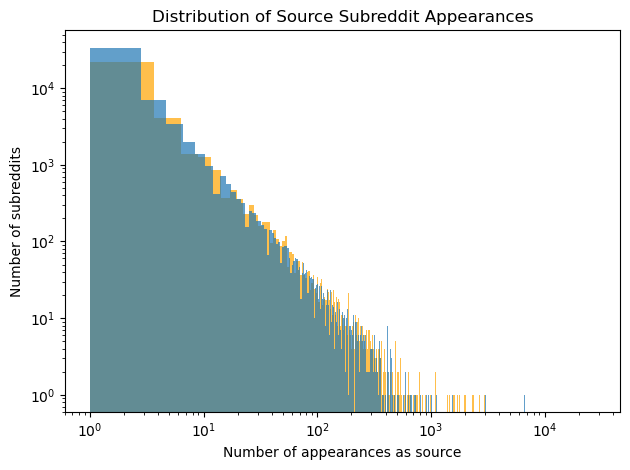

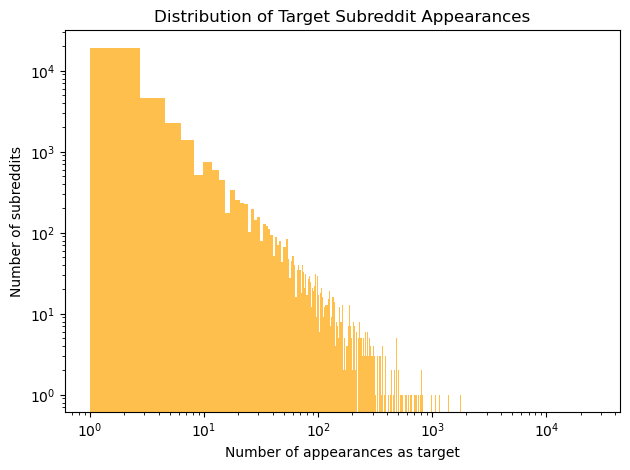

In [ ]:
source_counts = data['SOURCE_SUBREDDIT'].value_counts()
target_counts = data['TARGET_SUBREDDIT'].value_counts()

# --- Plot histogram of counts (distribution) ---
#plt.figure(figsize=(10, 6))
plt.hist(source_counts, bins=15000, alpha=0.7)
plt.hist(target_counts, bins=15000, alpha=0.7, color='orange')
plt.xscale('log')
plt.yscale('log')
plt.title("Distribution of Subreddit Appearances")
plt.xlabel("Number of appearances")
plt.ylabel("Number of subreddits")
plt.legend()
plt.tight_layout()
plt.show()

##plt.figure(figsize=(10, 6))
'''
plt.hist(target_counts, bins=15000, alpha=0.7, color='orange')
plt.xscale('log')
plt.yscale('log')
plt.title("Distribution of Target Subreddit Appearances")
plt.xlabel("Number of appearances as target")
plt.ylabel("Number of subreddits")
plt.tight_layout()
plt.show()
'''

